# P2: Advanced Lane Finding
## Import Packages

In [1]:
# importing packages necessary 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Process

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Supporting Functions

In [2]:
def calibrate(calibration_dir, nx, ny):
    """ Calibrates a camera using a directory of calibration images
    Requires the number of x- and y- inner corners within the calibration checkerboard
    Returns the associated pairs of object point and image point arrays
    """
    # set up empty arrays to store calibration values
    objpoints, imgpoints = [], [] 
    
    # populate the objpoints array
    # we will re-use this as a constant across the entire directory of calibration images
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        
    # calibrate using each image in our calibration folder
    cal_paths = os.listdir(calibration_dir)
    for cal_path in cal_paths:
        cal = mpimg.imread(calibration_dir+cal_path)

        # detect the corners from within the image
        gray = cv2.cvtColor(cal, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            # append the corner locations to our array
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return objpoints, imgpoints

def undistort(img):
    """ Used camera calibration to undistort an image
    Returns the undistorted image
    """
    # grab the calibration arrays using the source directory
    # we expect the checkerboard to have 9 x- and 6 y- inner corners
    objpoints, imgpoints = calibrate('camera_cal/', 9, 6)

    # obtain the calibration coefficents using the point arrays
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

    # undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

def b_threshold(img):
    """ Uses B values from the LAB color space to detect yellow lane lines
    Returns a thresholded version of the input image
    """
    # convert the image to LAB color space and grab the B channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]

    # apply the B channel threshold
    b_thresh_min, b_thresh_max = 150, 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    return b_binary

def l_threshold(img):
    """ Uses L values from the HLS color space to detect white lane lines
    Returns a thresholded version of the input image
    """
    # convert the image to HLS color space and grab the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]

    # apply the L channel threshold
    l_thresh_min, l_thresh_max = 200, 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    return l_binary

def sx_threshold(img):
    """ Uses Sobel X gradient values to identify lane edges
    Returns a thresholded version of the input image
    """
    # grab the sobel X gradient from a grayscaled version of the image 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # take the absolute value and scale it to fit the image's 256 range
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # apply the X gradient threshold
    thresh_min, thresh_max = 30, 100
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sx_binary

def threshold(img):
    """ Uses Sobel X coefficient, LAB B-values, and HLS L-values to identify lanes in an image
    Returns a binary threshold version of the input image 
    """
    # generate three different thresholds
    b_img = b_threshold(img)
    l_img = l_threshold(img)
    sx_img = sx_threshold(img)

    # combine the binary thresholds
    combined_binary = np.zeros_like(b_img)
    combined_binary[(b_img == 1) | (l_img == 1) | (sx_img == 1)] = 1
    
    return combined_binary

def warp(img):
    """ Warps an image so that it centers the lane and projects a birds-eye view.
    Uses defined source and destination points to generate a warp matrix.
    Returns the warped image.
    """
    size = (img.shape[1], img.shape[0])

    # define source and destination coordinates for the unwarped image
    # source: approximate expected coordinates of road positioned in camera view
    src = np.float32(
        [[(size[0]*.5-50), size[1]*.63],
        [size[0]*.16, size[1]],
        [size[0]*.86, size[1]],
        [(size[0]*.5+53), size[1]*.63]])
    # destination: positioned such that the left lane stretches top-to-bottom through the middle
    # of the left half of the screen, and the right lane through the middle of the right half
    dst = np.float32(
        [[size[0]*.25, 0],
        [size[0]*.25, size[1]],
        [size[0]*.75, size[1]],
        [size[0]*.75, 0]])

    # get the transformation matrix from the source/destination and use it to warp the image
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)
    
    return warped

def warp_inv(img):
    """ Inverse warps an image so that it converts a lane birds eye view into a centered view.
    Uses defined source and destination points to generate a warp matrix.
    Returns the inverse warped image.
    """
    size = (img.shape[1], img.shape[0])

    # define source and destination coordinates for the unwarped image
    # source: approximate expected coordinates of road positioned in camera view
    src = np.float32(
        [[(size[0]*.5-50), size[1]*.63],
        [size[0]*.16, size[1]],
        [size[0]*.86, size[1]],
        [(size[0]*.5+53), size[1]*.63]])
    # destination: positioned such that the left lane stretches top-to-bottom through the middle
    # of the left half of the screen, and the right lane through the middle of the right half
    dst = np.float32(
        [[size[0]*.25, 0],
        [size[0]*.25, size[1]],
        [size[0]*.75, size[1]],
        [size[0]*.75, 0]])

    # get the transformation matrix from the source/destination and use it to warp the image
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, size, flags=cv2.INTER_LINEAR)
    
    return warped

def histogram_lane_pixels(img, nwindows=9, margin=100, minpix=50):
    """ Uses histogram peaks to identify the origin of each lane edge.
    From there, iterates over several windows to find the associated lane pixels.
    Returns a list of X-, Y- coordinates for the pixels for each edge lane.
    """
    # generate a histogram of activated pixels by x-coordinate
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    # find the X value of the histogram peaks for the left and right sides
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # define window height based on number of windows
    window_height = np.int(img.shape[0]//nwindows)

    # identify all the nonzero pixels on the warped image (to consider for our lanes)
    nonzero = img.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])

    # establish the current x-coordinates of each lane edge and lists to store edge pixels
    leftx_current, rightx_current = leftx_base, rightx_base
    left_lane_inds, right_lane_inds = [], []

    # iterate through each window to find the lane pixels for that window
    for window in range(nwindows):
        # identify the window boundaries
        win_y_low = img.shape[0]-(window+1)*window_height
        win_y_high = img.shape[0]-window*window_height
        win_xleft_low, win_xleft_high = leftx_current-margin, leftx_current+margin
        win_xright_low, win_xright_high = rightx_current-margin, rightx_current+margin

        # identify the nonzero pixels within each window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                    (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                    (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # append the indices to the master list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # recenter the window for the next iteration depending on the number of pixels found
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # clean up the index lists (list of lists of indices --> list of indices)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # extract the pixels for the left and right lanes
    leftx, lefty = nonzerox[left_lane_inds], nonzeroy[left_lane_inds] 
    rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

def polyfits(lefty, leftx, righty, rightx):
    """ Fits polynomials to lists of coordinates of lane edge pixels.
    Returns the 2nd order polynomials that fit the lane edges.
    """
    # fit polynomials using lane edge pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def radius(left_fit, right_fit, ym_per_pix, xm_per_pix, y_eval):
    """ Finds the radius of curvature for each lane edge using the lane polyfits.
    Returns the radius of curvature of the more curved lane edge (smallest radius)
    """
    # calculate the radius of curvature for each lane edge
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/abs(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/abs(2*right_fit[0])
    
    return min(left_curverad, right_curverad)

def lanepos(left_fit, right_fit, y_eval, ym_per_pix, x_midpoint_exp):
    """ Finds the lane position with respect to the center of the lane.
    Returns the distance from the center in meters. A negative value implies that the vehicle is left of center.
    """
    # calculate the positions of the left lane edge and the right lane edge
    x_left = left_fit[0]*(y_eval*ym_per_pix)**2 + left_fit[1]*(y_eval*ym_per_pix) + left_fit[2]
    x_right = right_fit[0]*(y_eval*ym_per_pix)**2 + right_fit[1]*(y_eval*ym_per_pix) + right_fit[2]

    # calculate the actual midpoint bewteen lane edges and the distance from expected
    x_midpoint_act = (x_left + x_right)/2
    lane_position = x_midpoint_act-x_midpoint_exp
    
    return round(lane_position, 2)

## Display Test Images

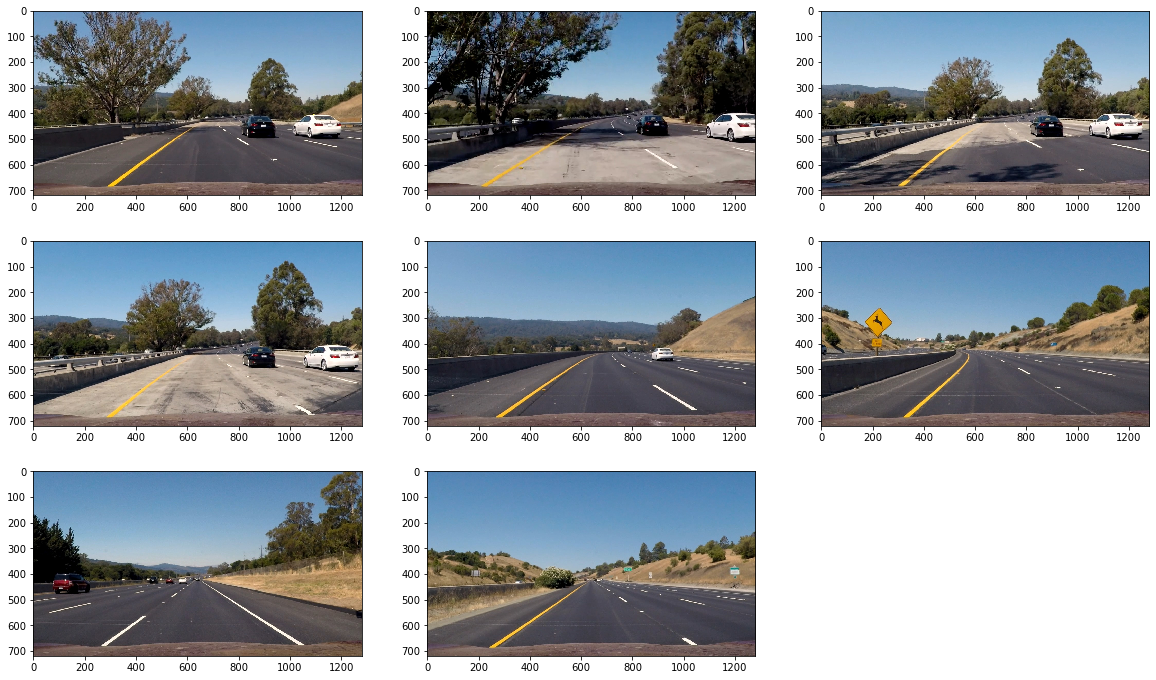

In [3]:
# display the entire directory of test images for reference
img_paths = os.listdir('test_images/')
plt.figure(figsize=(20,12))
cols, idx = 3, 0
for img_path in img_paths:
    img = mpimg.imread('test_images/'+img_path)
    plt.subplot(len(img_paths)/cols + 1, cols, idx+1)
    plt.imshow(img)
    idx += 1

## Compute Calibration and Undistort Image

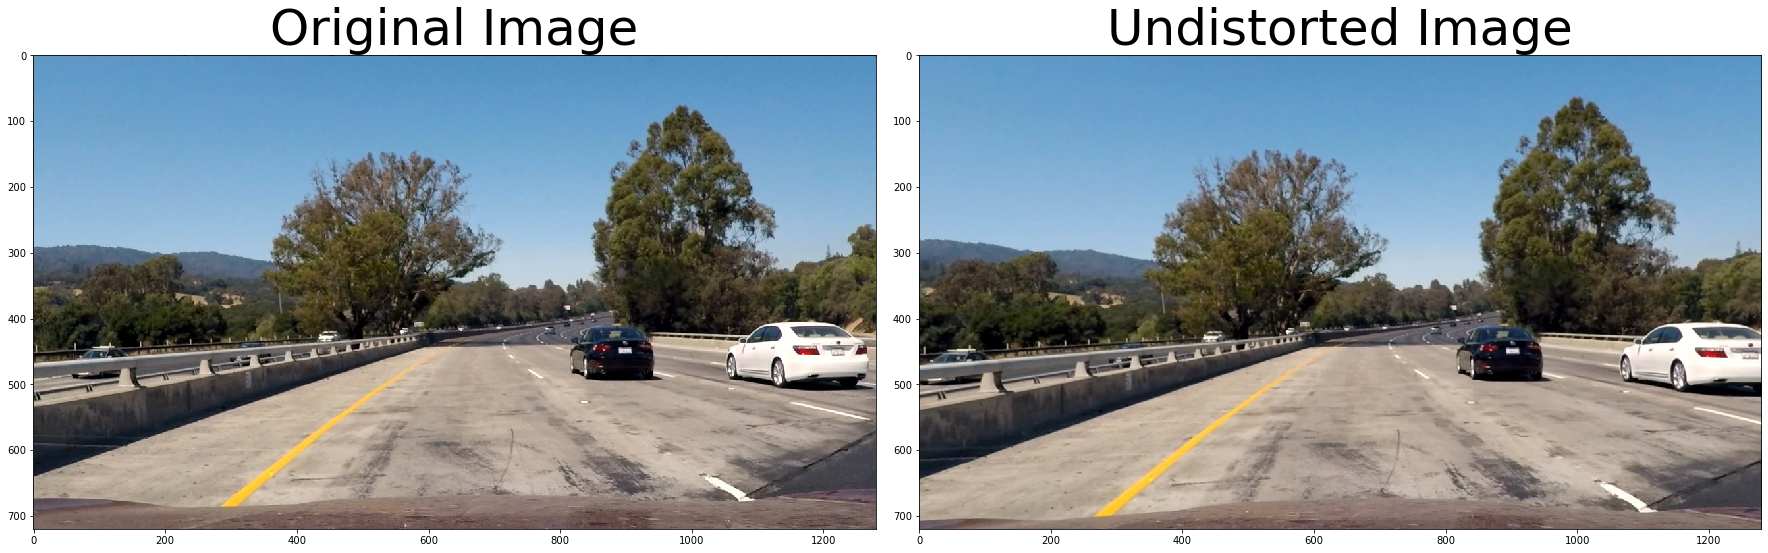

In [4]:
# identify the image to undistort
img = mpimg.imread('test_images/test1.jpg')

# grab the calibration arrays using the source directory
# we expect the checkerboard to have 9 x- and 6 y- inner corners
objpoints, imgpoints = calibrate('camera_cal/', 9, 6)

# obtain the calibration coefficents using the point arrays
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

# undistort the image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# display the undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient Thresholding

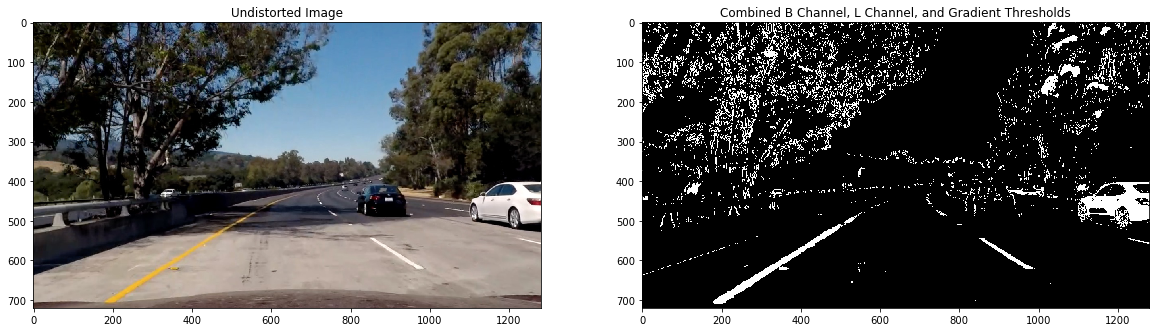

In [209]:
# grab the undistorted image
img = mpimg.imread('test_images/test5.jpg')
undist = undistort(img)

# generate thresholds to detect lane edges (using Sobel X coefficient),
# yellow lanes (LAB B values) and white lanes (HLS L values)
b_img = b_threshold(undist)
l_img = l_threshold(undist)
sx_img = sx_threshold(undist)

# combine the binary thresholds
combined_binary = np.zeros_like(b_img)
combined_binary[(b_img == 1) | (l_img == 1) | (sx_img == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image')
ax1.imshow(undist)
ax2.set_title('Combined B Channel, L Channel, and Gradient Thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Apply Perspective Transform

Text(0.5, 1.0, 'Warped Image with Destination Marked')

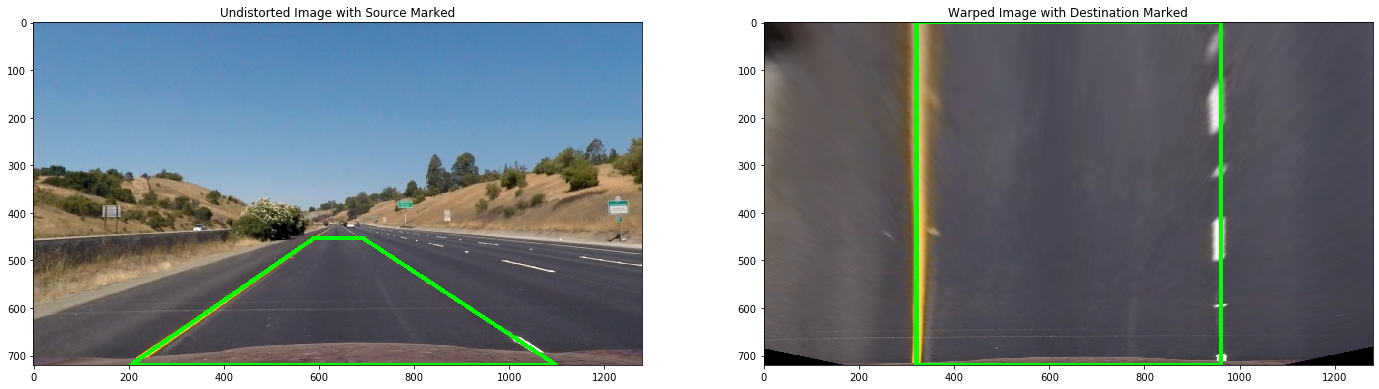

In [237]:
# grab the undistorted image
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort(img)
size = (undist.shape[1], undist.shape[0])

# define source and destination coordinates for the unwarped image
# source: approximate expected coordinates of road positioned in camera view
src = np.float32(
    [[(size[0]*.5-50), size[1]*.63],
    [size[0]*.16, size[1]],
    [size[0]*.86, size[1]],
    [(size[0]*.5+53), size[1]*.63]])
# destination: positioned such that the left lane stretches top-to-bottom through the middle
# of the left half of the screen, and the right lane through the middle of the right half
dst = np.float32(
    [[size[0]*.25, 0],
    [size[0]*.25, size[1]],
    [size[0]*.75, size[1]],
    [size[0]*.75, 0]])

# display the source range on top of the undistorted image
src_overlay = undist.copy()
cv2.polylines(src_overlay, np.int_([src]), True, (0,255, 0), 8)

# get the transformation matrix from the source/destination and use it to warp the image
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, size, flags=cv2.INTER_LINEAR)
cv2.polylines(warped, np.int_([dst]), True, (0,255, 0), 8)

# display the warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(src_overlay)
ax1.set_title('Undistorted Image with Source Marked')
ax2.imshow(warped)
ax2.set_title('Warped Image with Destination Marked')

## Identifying Lane Pixels Using Sliding Window

Text(0.5, 1.0, 'Lane Lines')

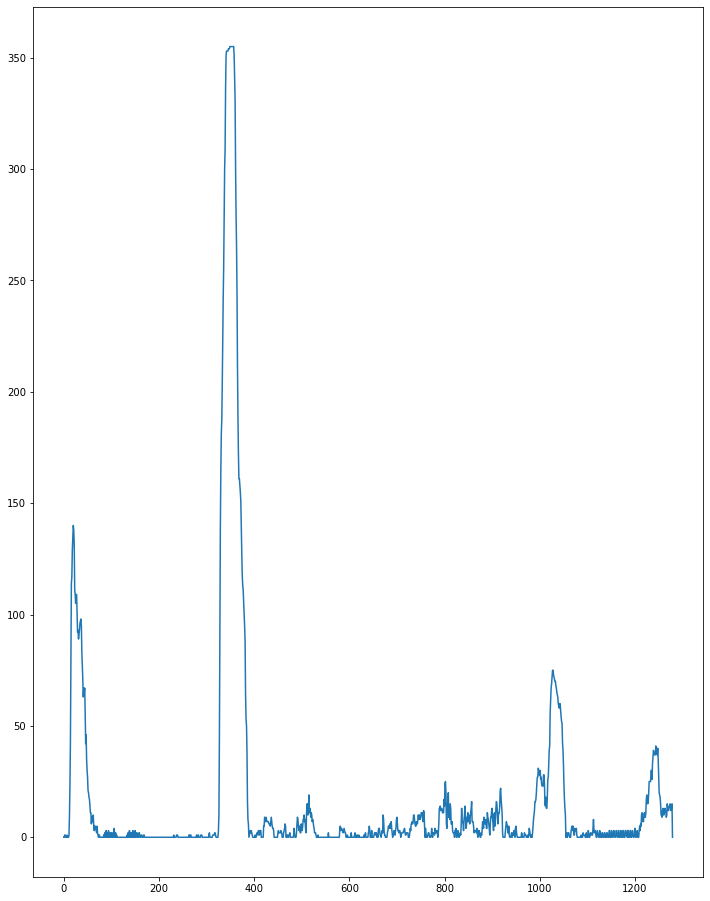

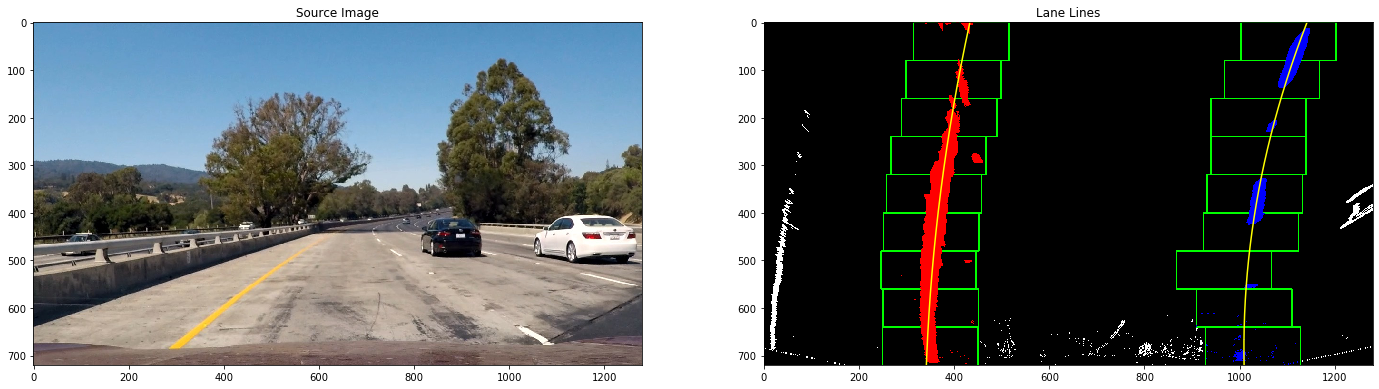

In [271]:
# grab the warped image and apply the binary threshold
img = mpimg.imread('test_images/test1.jpg')
undist = undistort(img)
warped = warp(undist)
thresh = threshold(warped)

# use a histogram to identify peaks where lane pixels are present
histogram = np.sum(thresh[thresh.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# find the X value of the histogram peaks for the left and right sides
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# prepare image to display sliding windows
out = np.dstack((thresh, thresh, thresh))*255

# sliding window hyperparameters
nwindows, margin, minpix = 9, 100, 50
window_height = np.int(thresh.shape[0]//nwindows)

# identify all the nonzero pixels on the warped image (to consider for our lanes)
nonzero = thresh.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# establish the current x-coordinates of each lane edge
leftx_current = leftx_base
rightx_current = rightx_base

# these lists will store the pixels of each lane edge
left_lane_inds, right_lane_inds = [], []

# iterate through each window to find the lane pixels for that window
for window in range(nwindows):
    # identify the window boundaries
    win_y_low = thresh.shape[0]-(window+1)*window_height
    win_y_high = thresh.shape[0]-window*window_height
    win_xleft_low = leftx_current-margin
    win_xleft_high = leftx_current+margin
    win_xright_low = rightx_current-margin
    win_xright_high = rightx_current+margin

    # draw the windows
    cv2.rectangle(out,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

    # identify the nonzero pixels within each window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

    # append the indices to the master list
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # recenter the window for the next iteration depending on the number of pixels found
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# clean up the index lists (list of lists of indices --> list of indices)
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# extract the pixels for the left and right lanes
leftx, lefty = nonzerox[left_lane_inds], nonzeroy[left_lane_inds] 
rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]

# fit polynomials to each list of pixels
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# generate list of x-coordinates paired with shape y-values
ploty = np.linspace(0, thresh.shape[0]-1, thresh.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# display the warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Source Image')

# display the lane pixels and associated polynomial
out[lefty, leftx] = [255, 0, 0]
out[righty, rightx] = [0, 0, 255]
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.imshow(out, cmap='gray')
ax2.set_title('Lane Lines')

## Determine Lane Curvature and Vehicle Position

In [26]:
# obtain the left and right lane edge pixels from the undistorted+warped+thresholded image
img = mpimg.imread('test_images/straight_lines2.jpg')
undist = undistort(img)
warped = warp(undist)
thresh = threshold(warped)
leftx, lefty, rightx, righty = histogram_lane_pixels(thresh)

# define meters-per-pixel constants in each direction for this camera and lane view
ym_per_pix = 30/720
xm_per_pix = 3.7/700

# fit polynomials using lane edge pixels
# convert these to real-world values by applying the pixel->meter constants
left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# obtain the max y-value, this is where we will obtain the radius of curvature
y_eval = thresh.shape[0]

# calculate the radius of curvature for each lane edge
left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**(3/2))/abs(2*left_fit[0])
right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**(3/2))/abs(2*right_fit[0])

# calculate the positions of the left lane edge, right lane edge, and expected center of the lane
x_midpoint_exp = (thresh.shape[1]/2)*xm_per_pix
x_left = left_fit[0]*(y_eval*ym_per_pix)**2 + left_fit[1]*(y_eval*ym_per_pix) + left_fit[2]
x_right = right_fit[0]*(y_eval*ym_per_pix)**2 + right_fit[1]*(y_eval*ym_per_pix) + right_fit[2]

# calculate the actual midpoint bewteen lane edges and the distance from expected
x_midpoint_act = (x_left + x_right)/2
lane_position = x_midpoint_act-x_midpoint_exp

print("Radius of Curvature =", int(min(left_curverad, right_curverad)), "(m)")
print("Vehicle is", abs(round(lane_position, 2)), "m", "right" if (lane_position>0) else "left", "of center")

Radius of Curvature = 6205 (m)
Vehicle is 0.03 m right of center


## Draw the Lane Back onto the Original Image

Text(0.5, 1.0, 'Lane Lines')

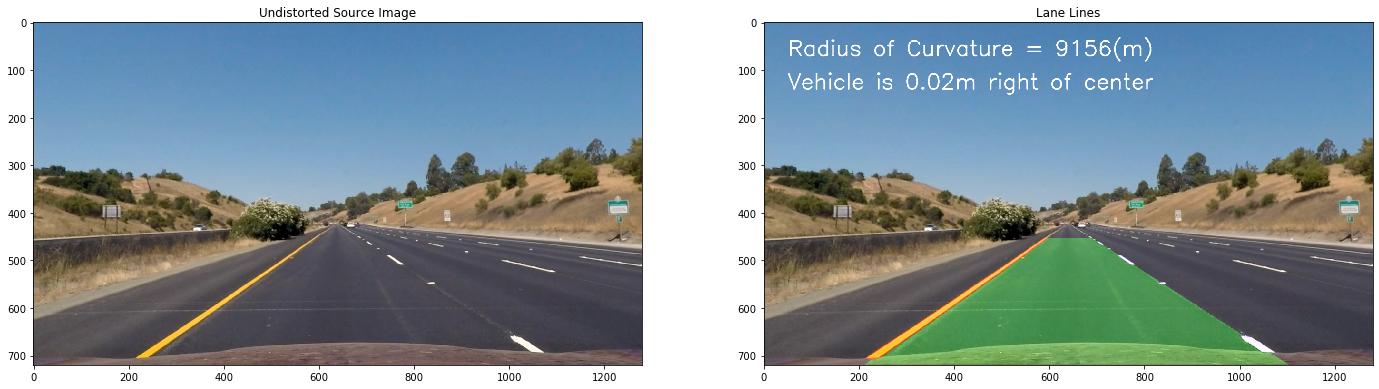

In [16]:
# obtain the left and right lane edge pixels from the undistorted+warped+thresholded image
img = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort(img)
warped = warp(undist)
thresh = threshold(warped)
leftx, lefty, rightx, righty = histogram_lane_pixels(thresh)
left_fit, right_fit = polyfits(lefty, leftx, righty, rightx)

# display the undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(undist)
ax1.set_title('Undistorted Source Image')

# create an image to draw the lines on
warp_zero = np.zeros_like(undist[:,:,0]).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# find the lane parameters
ploty = np.linspace(0, thresh.shape[0]-1, thresh.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
color_warp[lefty, leftx] = [255, 0, 0]
color_warp[righty, rightx] = [0, 0, 255]

# warp the image back to original image space and combine results
newwarp = warp_inv(color_warp) 
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

# obtains the radius of curvature and distance from center
ym_per_pix, xm_per_pix = 30/720, 3.7/700
left_fit_m, right_fit_m = polyfits(lefty*ym_per_pix, leftx*xm_per_pix, righty*ym_per_pix, rightx*xm_per_pix)
rad = radius(left_fit_m, right_fit_m, ym_per_pix, xm_per_pix, thresh.shape[0])
lane_pos = lanepos(left_fit_m, right_fit_m, thresh.shape[0], ym_per_pix, (thresh.shape[1]/2)*xm_per_pix)

# display the curavture and distance from center onto image
font = cv2.FONT_HERSHEY_SIMPLEX
rad_string = "Radius of Curvature = "+str(int(rad))+"(m)"
pos_string = "Vehicle is "+str(abs(lane_pos))+"m "+("right" if (lane_pos>0) else "left")+" of center"
cv2.putText(result, rad_string, (50,70), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(result, pos_string, (50,140), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

# display the output
ax2.imshow(result)
ax2.set_title('Lane Lines')

## Define Line Class to Aid Video Processing

In [3]:
class Line():
    """Line class retains position information and other metadata regarding the lines that form the
    left and right lane boundaries.

    Attributes:
        detected: boolean indicating whether the line was detected in the previous iteration
        recent_xfitted: array containing x values of the last n fits of the line
        bestx: array of average x values of the fitted line over the last n iterations
        best_fit: array of polynomial coefficients averaged over the last n iterations
        current_fit: array of polynomial coefficients for the most recent fit
        radius_of_curvature: float radius of curvature of the line in m
        line_base_pos: float distance in meters of vehicle center from the line
        diffs: array of floats indicating the difference in fit coefficients between last and new fits
        allx: array of x values for detected line pixels
        ally: array of y values for detected line pixels
        n_iterations: int representing the iterations to consider for above values
        current_iteration: int representing the current iteration
    """
    
    def __init__(self):
        """Initializes a Line with default values for Line attributes."""
        self.detected = False
        self.recent_xfitted = []
        self.bestx = None
        self.best_fit = None
        self.current_fit = [np.array([False])]
        self.radius_of_curvature = None
        self.line_base_pos = None
        self.diffs = np.array([0,0,0], dtype='float')
        self.allx = None
        self.ally = None
        self.n_iterations = 10
        self.current_iteration = 0
        
    def __str__(self):
        """Prints a description of the Line instances."""
        return "Line with radius of curvature "+str(self.radius_of_curvature)+" and base position "+str(self.line_base_pos)

## Build Slow Pipeline for Video Processing

In [23]:
def process_image(image):
    undist = undistort(image)
    warped = warp(undist)
    thresh = threshold(warped)
    
    # obtain the left and right lane edge pixels
    leftx, lefty, rightx, righty = histogram_lane_pixels(thresh)
    left_fit, right_fit = polyfits(lefty, leftx, righty, rightx)

    # find the lane parameters
    ploty = np.linspace(0, thresh.shape[0]-1, thresh.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # create an image to draw the lines on
    warp_zero = np.zeros_like(undist[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]

    # warp the image back to original image space and combine results
    newwarp = warp_inv(color_warp) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # obtains the radius of curvature and distance from center
    ym_per_pix, xm_per_pix = 30/720, 3.7/700
    left_fit_m, right_fit_m = polyfits(lefty*ym_per_pix, leftx*xm_per_pix, righty*ym_per_pix, rightx*xm_per_pix)
    rad = radius(left_fit_m, right_fit_m, ym_per_pix, xm_per_pix, thresh.shape[0])
    lane_pos = lanepos(left_fit_m, right_fit_m, thresh.shape[0], ym_per_pix, (thresh.shape[1]/2)*xm_per_pix)

    # display the curavture and distance from center onto image
    font = cv2.FONT_HERSHEY_SIMPLEX
    rad_string = "Radius of Curvature = "+str(int(rad))+"(m)"
    pos_string = "Vehicle is "+str(abs(lane_pos))+"m "+("right" if (lane_pos>0) else "left")+" of center"
    cv2.putText(result, rad_string, (50,70), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, pos_string, (50,140), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

    return result

## Test the Pipeline on Videos

In [27]:
# define Lines to store data for the left and right lane edges
left_line, right_line = Line(), Line()

# process the video pipeline
vid_output = 'videos_output/harder_challenge_video_test.mp4'
##clip1 = VideoFileClip("challenge_video.mp4").subclip(4,6)
clip1 = VideoFileClip("harder_challenge_video.mp4")
vid_clip = clip1.fl_image(process_image_smart)
%time vid_clip.write_videofile(vid_output, audio=False)

                                                            
                                                             

t:   2%|▏         | 1/60 [58:24<57:26:23, 3504.81s/it, now=None]

                                                            [A
                                                             

t:   2%|▏         | 1/60 [58:24<57:26:24, 3504.82s/it, now=None]

t:   5%|▌         | 3/60 [58:19<01:36,  1.69s/it, now=None]


t:   0%|          | 0/1199 [00:00<?, ?it/s, now=None]

Moviepy - Building video videos_output/harder_challenge_video_test.mp4.
Moviepy - Writing video videos_output/harder_challenge_video_test.mp4






t:   0%|          | 2/1199 [00:02<24:24,  1.22s/it, now=None]


t:   0%|          | 3/1199 [00:04<32:03,  1.61s/it, now=None]


t:   0%|          | 4/1199 [00:07<37:11,  1.87s/it, now=None]


t:   0%|          | 5/1199 [00:09<40:47,  2.05s/it, now=None]


t:   1%|          | 6/1199 [00:12<43:14,  2.17s/it, now=None]


t:   1%|          | 7/1199 [00:14<44:53,  2.26s/it, now=None]


t:   1%|          | 8/1199 [00:17<45:59,  2.32s/it, now=None]


t:   1%|          | 9/1199 [00:19<46:44,  2.36s/it, now=None]


t:   1%|          | 10/1199 [00:22<47:20,  2.39s/it, now=None]


t:   1%|          | 11/1199 [00:24<47:40,  2.41s/it, now=None]


t:   1%|          | 12/1199 [00:27<47:55,  2.42s/it, now=None]


t:   1%|          | 13/1199 [00:29<48:01,  2.43s/it, now=None]


t:   1%|          | 14/1199 [00:31<48:03,  2.43s/it, now=None]


t:   1%|▏         | 15/1199 [00:34<48:03,  2.44s/it, now=None]


t:   1%|▏         | 16/1199 [00:36<48:04,  2.44s/it, now=None]


t:   1%|▏         | 17/1199 [0

t:   9%|▉         | 112/1199 [04:33<44:19,  2.45s/it, now=None]


t:   9%|▉         | 113/1199 [04:35<44:15,  2.45s/it, now=None]


t:  10%|▉         | 114/1199 [04:37<44:11,  2.44s/it, now=None]


t:  10%|▉         | 115/1199 [04:40<44:05,  2.44s/it, now=None]


t:  10%|▉         | 116/1199 [04:42<44:03,  2.44s/it, now=None]


t:  10%|▉         | 117/1199 [04:45<44:00,  2.44s/it, now=None]


t:  10%|▉         | 118/1199 [04:47<44:01,  2.44s/it, now=None]


t:  10%|▉         | 119/1199 [04:50<43:53,  2.44s/it, now=None]


t:  10%|█         | 120/1199 [04:52<43:51,  2.44s/it, now=None]


t:  10%|█         | 121/1199 [04:54<43:51,  2.44s/it, now=None]


t:  10%|█         | 122/1199 [04:57<44:07,  2.46s/it, now=None]


t:  10%|█         | 123/1199 [05:00<44:40,  2.49s/it, now=None]


t:  10%|█         | 124/1199 [05:02<44:51,  2.50s/it, now=None]


t:  10%|█         | 125/1199 [05:05<44:28,  2.48s/it, now=None]


t:  11%|█         | 126/1199 [05:07<44:15,  2.48s/it, now=None]


t:  11%|█ 

t:  18%|█▊        | 221/1199 [08:59<40:44,  2.50s/it, now=None]


t:  19%|█▊        | 222/1199 [09:01<40:41,  2.50s/it, now=None]


t:  19%|█▊        | 223/1199 [09:04<40:29,  2.49s/it, now=None]


t:  19%|█▊        | 224/1199 [09:06<40:19,  2.48s/it, now=None]


t:  19%|█▉        | 225/1199 [09:09<40:15,  2.48s/it, now=None]


t:  19%|█▉        | 226/1199 [09:11<40:07,  2.47s/it, now=None]


t:  19%|█▉        | 227/1199 [09:14<39:58,  2.47s/it, now=None]


t:  19%|█▉        | 228/1199 [09:16<39:52,  2.46s/it, now=None]


t:  19%|█▉        | 229/1199 [09:18<39:47,  2.46s/it, now=None]


t:  19%|█▉        | 230/1199 [09:21<39:43,  2.46s/it, now=None]


t:  19%|█▉        | 231/1199 [09:23<39:38,  2.46s/it, now=None]


t:  19%|█▉        | 232/1199 [09:26<39:33,  2.45s/it, now=None]


t:  19%|█▉        | 233/1199 [09:28<39:35,  2.46s/it, now=None]


t:  20%|█▉        | 234/1199 [09:31<39:32,  2.46s/it, now=None]


t:  20%|█▉        | 235/1199 [09:33<39:28,  2.46s/it, now=None]


t:  20%|█▉

t:  28%|██▊       | 330/1199 [13:26<35:46,  2.47s/it, now=None]


t:  28%|██▊       | 331/1199 [13:28<35:36,  2.46s/it, now=None]


t:  28%|██▊       | 332/1199 [13:31<35:28,  2.46s/it, now=None]


t:  28%|██▊       | 333/1199 [13:33<35:19,  2.45s/it, now=None]


t:  28%|██▊       | 334/1199 [13:36<35:15,  2.45s/it, now=None]


t:  28%|██▊       | 335/1199 [13:38<35:11,  2.44s/it, now=None]


t:  28%|██▊       | 336/1199 [13:41<35:05,  2.44s/it, now=None]


t:  28%|██▊       | 337/1199 [13:43<35:04,  2.44s/it, now=None]


t:  28%|██▊       | 338/1199 [13:45<35:00,  2.44s/it, now=None]


t:  28%|██▊       | 339/1199 [13:48<34:58,  2.44s/it, now=None]


t:  28%|██▊       | 340/1199 [13:50<34:57,  2.44s/it, now=None]


t:  28%|██▊       | 341/1199 [13:53<34:54,  2.44s/it, now=None]


t:  29%|██▊       | 342/1199 [13:55<34:50,  2.44s/it, now=None]


t:  29%|██▊       | 343/1199 [13:58<34:49,  2.44s/it, now=None]


t:  29%|██▊       | 344/1199 [14:00<34:43,  2.44s/it, now=None]


t:  29%|██

t:  37%|███▋      | 439/1199 [17:58<31:15,  2.47s/it, now=None]


t:  37%|███▋      | 440/1199 [18:00<31:11,  2.47s/it, now=None]


t:  37%|███▋      | 441/1199 [18:02<31:03,  2.46s/it, now=None]


t:  37%|███▋      | 442/1199 [18:05<30:59,  2.46s/it, now=None]


t:  37%|███▋      | 443/1199 [18:07<30:59,  2.46s/it, now=None]


t:  37%|███▋      | 444/1199 [18:10<30:55,  2.46s/it, now=None]


t:  37%|███▋      | 445/1199 [18:12<30:52,  2.46s/it, now=None]


t:  37%|███▋      | 446/1199 [18:15<30:47,  2.45s/it, now=None]


t:  37%|███▋      | 447/1199 [18:17<30:43,  2.45s/it, now=None]


t:  37%|███▋      | 448/1199 [18:20<30:42,  2.45s/it, now=None]


t:  37%|███▋      | 449/1199 [18:22<30:45,  2.46s/it, now=None]


t:  38%|███▊      | 450/1199 [18:25<30:40,  2.46s/it, now=None]


t:  38%|███▊      | 451/1199 [18:27<30:35,  2.45s/it, now=None]


t:  38%|███▊      | 452/1199 [18:29<30:32,  2.45s/it, now=None]


t:  38%|███▊      | 453/1199 [18:32<30:27,  2.45s/it, now=None]


t:  38%|██

t:  46%|████▌     | 548/1199 [22:24<26:31,  2.45s/it, now=None]


t:  46%|████▌     | 549/1199 [22:27<26:28,  2.44s/it, now=None]


t:  46%|████▌     | 550/1199 [22:29<26:23,  2.44s/it, now=None]


t:  46%|████▌     | 551/1199 [22:32<26:19,  2.44s/it, now=None]


t:  46%|████▌     | 552/1199 [22:34<26:14,  2.43s/it, now=None]


t:  46%|████▌     | 553/1199 [22:37<26:24,  2.45s/it, now=None]


t:  46%|████▌     | 554/1199 [22:39<26:21,  2.45s/it, now=None]


t:  46%|████▋     | 555/1199 [22:41<26:16,  2.45s/it, now=None]


t:  46%|████▋     | 556/1199 [22:44<26:11,  2.44s/it, now=None]


t:  46%|████▋     | 557/1199 [22:46<26:09,  2.44s/it, now=None]


t:  47%|████▋     | 558/1199 [22:49<26:05,  2.44s/it, now=None]


t:  47%|████▋     | 559/1199 [22:51<26:00,  2.44s/it, now=None]


t:  47%|████▋     | 560/1199 [22:54<25:56,  2.44s/it, now=None]


t:  47%|████▋     | 561/1199 [22:56<25:57,  2.44s/it, now=None]


t:  47%|████▋     | 562/1199 [22:59<26:07,  2.46s/it, now=None]


t:  47%|██

t:  55%|█████▍    | 657/1199 [26:52<22:24,  2.48s/it, now=None]


t:  55%|█████▍    | 658/1199 [26:54<22:23,  2.48s/it, now=None]


t:  55%|█████▍    | 659/1199 [26:57<22:31,  2.50s/it, now=None]


t:  55%|█████▌    | 660/1199 [27:00<22:40,  2.52s/it, now=None]


t:  55%|█████▌    | 661/1199 [27:02<22:34,  2.52s/it, now=None]


t:  55%|█████▌    | 662/1199 [27:05<22:26,  2.51s/it, now=None]


t:  55%|█████▌    | 663/1199 [27:07<22:23,  2.51s/it, now=None]


t:  55%|█████▌    | 664/1199 [27:10<22:17,  2.50s/it, now=None]


t:  55%|█████▌    | 665/1199 [27:12<22:14,  2.50s/it, now=None]


t:  56%|█████▌    | 666/1199 [27:15<22:08,  2.49s/it, now=None]


t:  56%|█████▌    | 667/1199 [27:17<22:02,  2.49s/it, now=None]


t:  56%|█████▌    | 668/1199 [27:20<22:00,  2.49s/it, now=None]


t:  56%|█████▌    | 669/1199 [27:22<21:59,  2.49s/it, now=None]


t:  56%|█████▌    | 670/1199 [27:24<21:55,  2.49s/it, now=None]


t:  56%|█████▌    | 671/1199 [27:27<21:52,  2.49s/it, now=None]


t:  56%|██

t:  64%|██████▍   | 766/1199 [31:21<17:36,  2.44s/it, now=None]


t:  64%|██████▍   | 767/1199 [31:24<17:43,  2.46s/it, now=None]


t:  64%|██████▍   | 768/1199 [31:26<17:41,  2.46s/it, now=None]


t:  64%|██████▍   | 769/1199 [31:29<17:37,  2.46s/it, now=None]


t:  64%|██████▍   | 770/1199 [31:31<17:29,  2.45s/it, now=None]


t:  64%|██████▍   | 771/1199 [31:34<17:21,  2.43s/it, now=None]


t:  64%|██████▍   | 772/1199 [31:36<17:24,  2.45s/it, now=None]


t:  64%|██████▍   | 773/1199 [31:39<17:31,  2.47s/it, now=None]


t:  65%|██████▍   | 774/1199 [31:41<17:31,  2.47s/it, now=None]


t:  65%|██████▍   | 775/1199 [31:44<17:32,  2.48s/it, now=None]


t:  65%|██████▍   | 776/1199 [31:46<17:32,  2.49s/it, now=None]


t:  65%|██████▍   | 777/1199 [31:49<17:34,  2.50s/it, now=None]


t:  65%|██████▍   | 778/1199 [31:51<17:22,  2.48s/it, now=None]


t:  65%|██████▍   | 779/1199 [31:54<17:25,  2.49s/it, now=None]


t:  65%|██████▌   | 780/1199 [31:56<17:42,  2.54s/it, now=None]


t:  65%|██

t:  73%|███████▎  | 875/1199 [35:49<13:28,  2.50s/it, now=None]


t:  73%|███████▎  | 876/1199 [35:52<13:27,  2.50s/it, now=None]


t:  73%|███████▎  | 877/1199 [35:54<13:24,  2.50s/it, now=None]


t:  73%|███████▎  | 878/1199 [35:57<13:21,  2.50s/it, now=None]


t:  73%|███████▎  | 879/1199 [35:59<13:18,  2.49s/it, now=None]


t:  73%|███████▎  | 880/1199 [36:02<13:13,  2.49s/it, now=None]


t:  73%|███████▎  | 881/1199 [36:04<13:10,  2.49s/it, now=None]


t:  74%|███████▎  | 882/1199 [36:07<13:06,  2.48s/it, now=None]


t:  74%|███████▎  | 883/1199 [36:09<13:04,  2.48s/it, now=None]


t:  74%|███████▎  | 884/1199 [36:12<13:01,  2.48s/it, now=None]


t:  74%|███████▍  | 885/1199 [36:14<12:56,  2.47s/it, now=None]


t:  74%|███████▍  | 886/1199 [36:17<12:53,  2.47s/it, now=None]


t:  74%|███████▍  | 887/1199 [36:19<12:48,  2.46s/it, now=None]


t:  74%|███████▍  | 888/1199 [36:22<12:45,  2.46s/it, now=None]


t:  74%|███████▍  | 889/1199 [36:24<12:40,  2.45s/it, now=None]


t:  74%|██

t:  82%|████████▏ | 984/1199 [40:13<08:35,  2.40s/it, now=None]


t:  82%|████████▏ | 985/1199 [40:15<08:34,  2.40s/it, now=None]


t:  82%|████████▏ | 986/1199 [40:18<08:31,  2.40s/it, now=None]


t:  82%|████████▏ | 987/1199 [40:20<08:29,  2.41s/it, now=None]


t:  82%|████████▏ | 988/1199 [40:23<08:26,  2.40s/it, now=None]


t:  82%|████████▏ | 989/1199 [40:25<08:23,  2.40s/it, now=None]


t:  83%|████████▎ | 990/1199 [40:27<08:20,  2.40s/it, now=None]


t:  83%|████████▎ | 991/1199 [40:30<08:18,  2.40s/it, now=None]


t:  83%|████████▎ | 992/1199 [40:32<08:21,  2.42s/it, now=None]


t:  83%|████████▎ | 993/1199 [40:35<08:29,  2.47s/it, now=None]


t:  83%|████████▎ | 994/1199 [40:37<08:29,  2.49s/it, now=None]


t:  83%|████████▎ | 995/1199 [40:40<08:31,  2.51s/it, now=None]


t:  83%|████████▎ | 996/1199 [40:43<08:33,  2.53s/it, now=None]


t:  83%|████████▎ | 997/1199 [40:45<08:43,  2.59s/it, now=None]


t:  83%|████████▎ | 998/1199 [40:48<08:50,  2.64s/it, now=None]


t:  83%|██

t:  91%|█████████ | 1092/1199 [44:59<04:50,  2.71s/it, now=None]


t:  91%|█████████ | 1093/1199 [45:02<04:45,  2.69s/it, now=None]


t:  91%|█████████ | 1094/1199 [45:04<04:38,  2.65s/it, now=None]


t:  91%|█████████▏| 1095/1199 [45:07<04:34,  2.64s/it, now=None]


t:  91%|█████████▏| 1096/1199 [45:09<04:31,  2.64s/it, now=None]


t:  91%|█████████▏| 1097/1199 [45:12<04:26,  2.61s/it, now=None]


t:  92%|█████████▏| 1098/1199 [45:14<04:17,  2.55s/it, now=None]


t:  92%|█████████▏| 1099/1199 [45:17<04:17,  2.57s/it, now=None]


t:  92%|█████████▏| 1100/1199 [45:20<04:16,  2.60s/it, now=None]


t:  92%|█████████▏| 1101/1199 [45:22<04:15,  2.61s/it, now=None]


t:  92%|█████████▏| 1102/1199 [45:25<04:11,  2.59s/it, now=None]


t:  92%|█████████▏| 1103/1199 [45:27<04:04,  2.54s/it, now=None]


t:  92%|█████████▏| 1104/1199 [45:30<04:00,  2.53s/it, now=None]


t:  92%|█████████▏| 1105/1199 [45:32<03:55,  2.51s/it, now=None]


t:  92%|█████████▏| 1106/1199 [45:35<03:53,  2.51s/it, now=Non

t: 100%|██████████| 1199/1199 [49:31<00:00,  2.51s/it, now=None]


                                                                
                                                             

t:   2%|▏         | 1/60 [1:47:59<106:11:40, 6479.67s/it, now=None]

                                                              [A
                                                                

t:   2%|▏         | 1/60 [1:47:59<106:11:41, 6479.69s/it, now=None]

t:   5%|▌         | 3/60 [1:47:54<01:36,  1.69s/it, now=None]

Moviepy - Done !
Moviepy - video ready videos_output/harder_challenge_video_test.mp4
CPU times: user 49min 5s, sys: 3min 19s, total: 52min 24s
Wall time: 49min 34s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

## Build Smart Pipeline Using Previous Frame Data

In [28]:
def process_image_smart(image):
    undist = undistort(image)
    warped = warp(undist)
    thresh = threshold(warped)
    
    # reset the lane detection strategy after n iterations
    # this "rescues" the lane in instances where the detection goes off track
    if left_line.current_iteration >= left_line.n_iterations or right_line.current_iteration >= right_line.n_iterations:
        left_line.current_iteration, right_line.current_iteration = 0, 0
        left_line.detected, right_line.detected = False, False
        
    # grab the fit values from the previous frame if lanes were found
    if left_line.detected and right_line.detected:
        color_warp = search_around_poly(thresh)
    else:
        color_warp = find_using_histogram(thresh)
    left_line.current_iteration += 1
    right_line.current_iteration += 1
    
    # warp the image back to original image space and combine results
    newwarp = warp_inv(color_warp) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # obtains the radius of curvature and distance from center
    ym_per_pix, xm_per_pix = 30/720, 3.7/700
    left_fit_m, right_fit_m = polyfits(left_line.ally*ym_per_pix, left_line.allx*xm_per_pix, right_line.ally*ym_per_pix, right_line.allx*xm_per_pix)
    rad = radius(left_fit_m, right_fit_m, ym_per_pix, xm_per_pix, thresh.shape[0])
    lane_pos = lanepos(left_fit_m, right_fit_m, thresh.shape[0], ym_per_pix, (thresh.shape[1]/2)*xm_per_pix)

    # display the curavture and distance from center onto image
    font = cv2.FONT_HERSHEY_SIMPLEX
    rad_string = "Radius of Curvature = "+str(int(rad))+"(m)"
    pos_string = "Vehicle is "+str(abs(lane_pos))+"m "+("right" if (lane_pos>0) else "left")+" of center"
    cv2.putText(result, rad_string, (50,70), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, pos_string, (50,140), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

    return result

def find_using_histogram(binary_warped):
    # obtain the left and right lane edge pixels
    leftx, lefty, rightx, righty = histogram_lane_pixels(binary_warped)
    left_fit, right_fit = polyfits(lefty, leftx, righty, rightx)

    # find the lane parameters
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # update lane Lines
    left_line.detected = True
    left_line.current_fit = left_fit
    left_line.allx, left_line.ally = leftx, lefty
    right_line.detected = True
    right_line.current_fit = right_fit
    right_line.allx, right_line.ally = rightx, righty

    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    color_warp[lefty, leftx] = [255, 0, 0]
    color_warp[righty, rightx] = [0, 0, 255]
    
    return color_warp

def search_around_poly(binary_warped):
    # grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy, nonzerox = np.array(nonzero[0]), np.array(nonzero[1])
    
    # grab the previous polyfit
    left_fit, right_fit = left_line.current_fit, right_line.current_fit

    # grab lane pixels within margin of the previously identified polyfit
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx, lefty = nonzerox[left_lane_inds], nonzeroy[left_lane_inds] 
    rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]
    
    # update lane pixels
    left_line.allx, left_line.ally = leftx, lefty
    right_line.allx, right_line.ally = rightx, righty

    # fit new polynomials
    left_fit, right_fit = polyfits(lefty, leftx, righty, rightx)
    left_line.current_fit, right_line.current_fit = left_fit, right_fit
    
    # find the polynomial x,y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]
    
    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # color in left and right line pixels
    cv2.fillPoly(out_img, np.int_([pts]), (0, 255, 0))
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    
    return result